In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import seaborn as sns

import torch


import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor


from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE, QuantileLoss
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameter

c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Benchmark

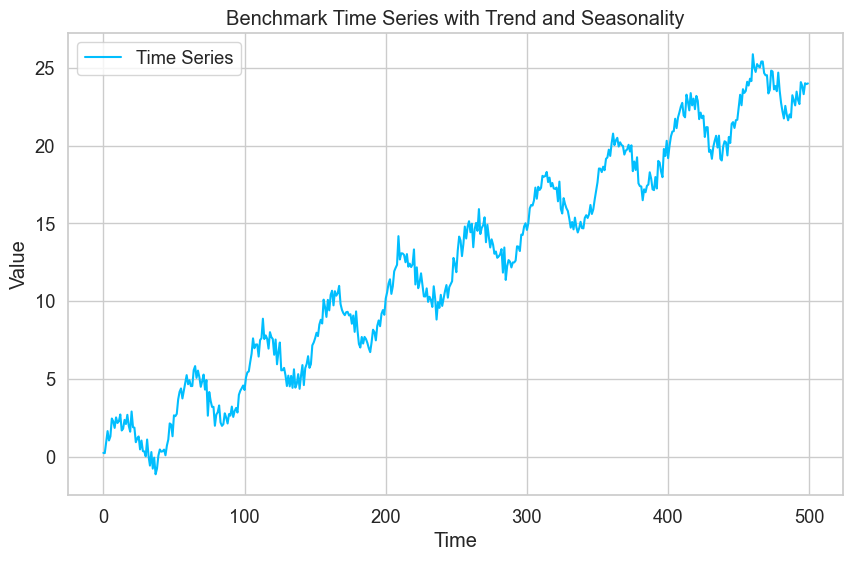

In [2]:
from functions_for_notebook import create_benchmark_data

%matplotlib inline
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

Colour_Palette = ["#01BEFE", "#FF7D00", "#FFDD00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(Colour_Palette))

n_points = 500
data, time_series, t = create_benchmark_data(n_points)


# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(data["Time"], data["Value"], label="Time Series")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Benchmark Time Series with Trend and Seasonality")
plt.legend()
plt.show()

# Save the data to a CSV file
data.to_csv("benchmark_time_series.csv", index=False)

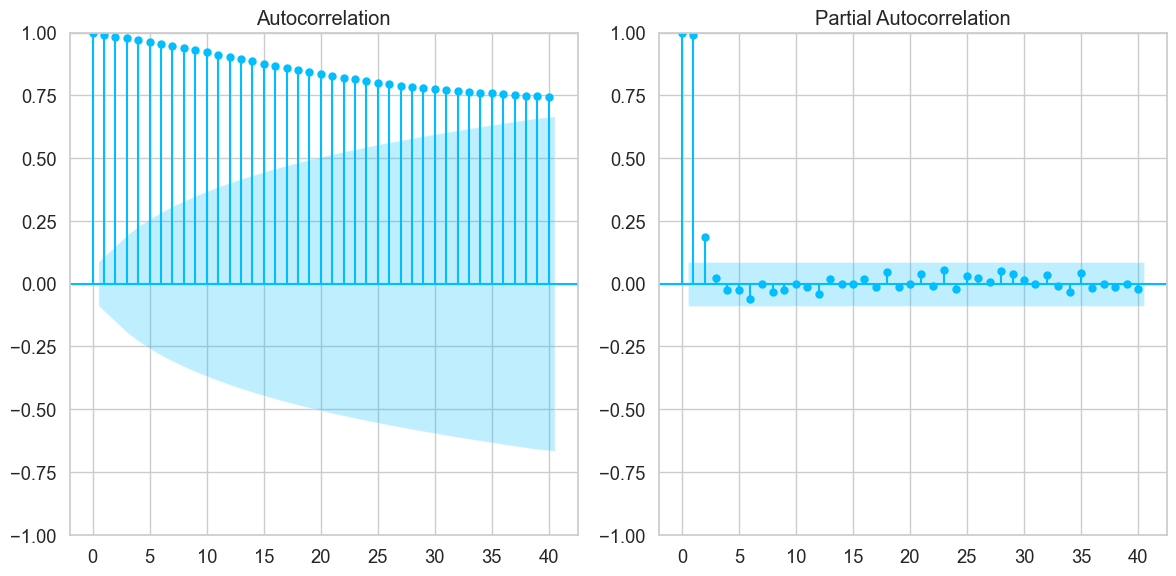

In [3]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(data["Value"], ax=plt.gca(), lags=40)
plt.title("Autocorrelation")
plt.subplot(122)
plot_pacf(data["Value"], ax=plt.gca(), lags=40, method="ywm")
plt.title("Partial Autocorrelation")
plt.tight_layout()
plt.show()

SARIMA seasone 50

In [4]:
seasonal_period = 50  # Same as in the data generation
sarima_model = SARIMAX(
    data["Value"], order=(2, 1, 2), seasonal_order=(1, 1, 1, seasonal_period)
).fit()

In [5]:
# Print model summary
print(sarima_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                Value   No. Observations:                  500
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 50)   Log Likelihood                -377.099
Date:                              Wed, 08 Jan 2025   AIC                            768.198
Time:                                      18:45:19   BIC                            796.947
Sample:                                           0   HQIC                           779.530
                                              - 500                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8032      0.387     -2.074      0.038      -1.562      -0.044
ar.L2         -0.01

In [6]:
# Forecast future values
forecast_steps = 50
forecast = sarima_model.get_forecast(steps=forecast_steps)
forecast_index = np.arange(n_points, n_points + forecast_steps)
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

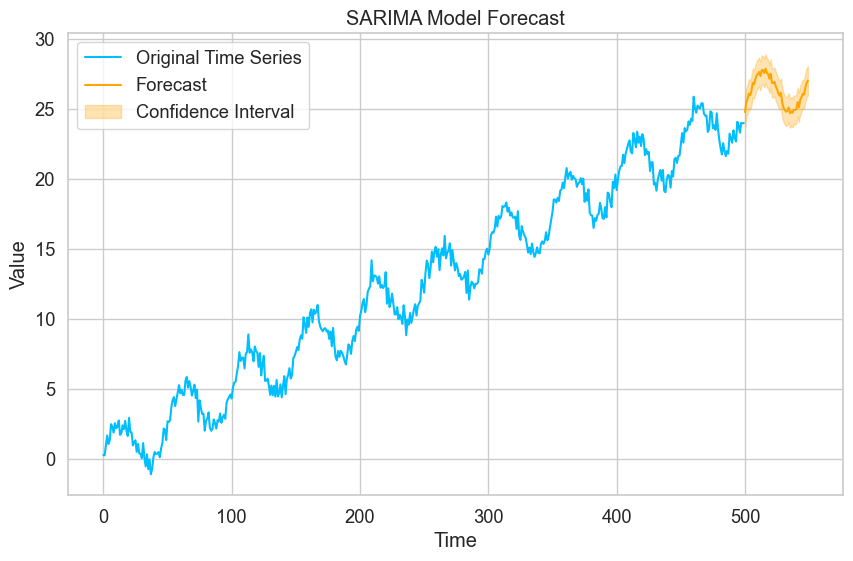

In [7]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data["Time"], data["Value"], label="Original Time Series")
plt.plot(forecast_index, forecast_values, label="Forecast", color="orange")
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="orange",
    alpha=0.3,
    label="Confidence Interval",
)
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("SARIMA Model Forecast")
plt.legend()
plt.show()

Dopasowanie SARIMA dla 450 pierwszych wartości

In [8]:
seasonal_period = 50  # Same as in the data generation
sarima_model_450 = SARIMAX(
    data["Value"][:450], order=(2, 1, 2), seasonal_order=(1, 1, 1, seasonal_period)
).fit()

# Forecast future values
forecast_steps = 50
forecast_450 = sarima_model_450.get_forecast(steps=forecast_steps)
forecast_index = np.arange(450, 450 + forecast_steps)
forecast_values = forecast_450.predicted_mean
forecast_ci = forecast_450.conf_int()

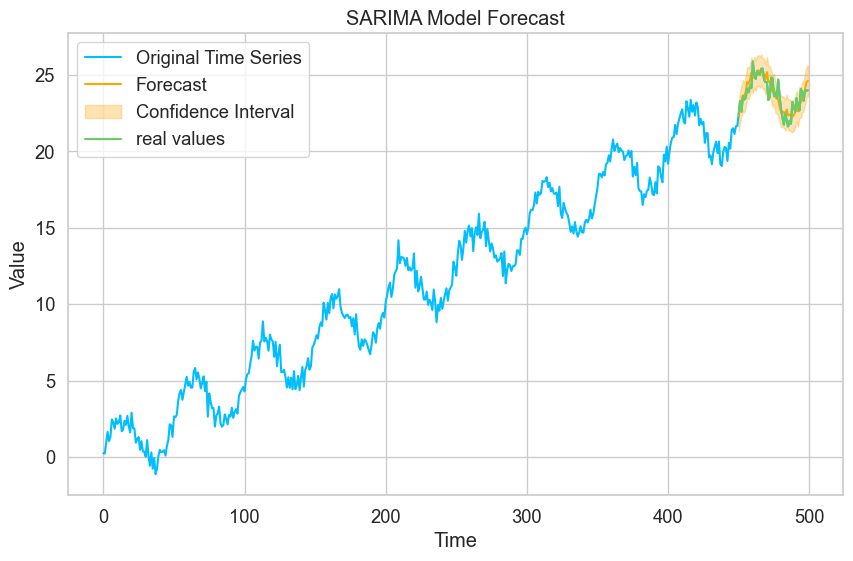

RMSE: 0.5723
R² Score: 0.7050


In [9]:
from functions_for_notebook import stats

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data["Time"], data["Value"], label="Original Time Series")
plt.plot(forecast_index, forecast_values, label="Forecast", color="orange")
plt.fill_between(
    forecast_index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color="orange",
    alpha=0.3,
    label="Confidence Interval",
)
plt.plot(data["Time"][450:], data["Value"][450:], label="real values", color="g")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("SARIMA Model Forecast")
plt.legend()
plt.show()

r2, rmse = stats(real_values=data["Value"][450:], test_predictions=forecast_values)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

SARIMA bardzo dobrze dopasowała się do danych, jednak ze względu na charakterystykę Benchmarku jest to oczekiwany rezultat

Rekurencyjne sieci neuronowe

In [3]:
from functions_for_notebook import data_transformation

(
    train_data,
    test_data,
    scaled_train,
    scaled_test,
    dataset_train,
    dataset_test,
    scaler,
) = data_transformation(data, 0.8)

In [4]:
from functions_for_notebook import create_sequences

sequence_length = 50  # Number of time steps to look back
X_train, y_train = create_sequences(scaled_train, sequence_length)
X_test, y_test = create_sequences(scaled_test, sequence_length)

print(y_train[0])

[0.17291092]


In [5]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

# Convert data to PyTorch tensors
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([350, 50, 1]) torch.Size([350, 1])
torch.Size([50, 50, 1]) torch.Size([50, 1])


Cuda check

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

True
12.1
NVIDIA GeForce RTX 4060 Ti


In [62]:
group = ["group" for i in time_series]
data = pd.DataFrame({"Time": t, "Value": time_series})
data["Group"] = group
data.sample(10, random_state=521)

,Time,Value,Group
69,69,4.496534,group
263,263,14.633860,group
304,304,16.153057,group
19,19,1.612942,group
71,71,5.282526,group
104,104,6.082864,group
213,213,12.971749,group
472,472,23.578654,group
164,164,10.646263,group
371,371,19.762506,group


In [63]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[["Value"]])  # Dopasowanie do danych
data["Value"] = scaled_data  # Nadpisanie znormalizowanych wartości

 Tworzenie zbiorów danych dla modelu szeregów czasowych

In [64]:
max_prediction_length = 50
max_encoder_length = 128
training_cutoff = data["Time"].max() - max_prediction_length
training_cutoff

training = TimeSeriesDataSet(
    data[lambda x: x.Time <= training_cutoff],
    time_idx="Time",
    target="Value",
    group_ids=["Group"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["Time"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["Value"],  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

Tworzenie zestawu walidacyjnego

In [65]:
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)


batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [68]:
pl.seed_everything(42)  # Ustawienie ziarna

early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)  # Callback monitorujący metrykę walidacyjną i zatrzymujący trening, jeśli model przestaje się poprawiać.


lr_logger = (
    LearningRateMonitor()
)  # Callback rejestrujący zmiany w szybkości uczenia podczas treningu.
# logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(  # Konfiguracja trainera w Pytorch Lightning, zarządza procesem
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    callbacks=[lr_logger, early_stop_callback],
    # logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(  # Tworzenie modelu Temporal fusion
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 18.6k


c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defau

In [69]:
trainer.fit(  # Trenwoanie modelu
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 96     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm |

c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_ev

Epoch 13: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s, v_num=80, train_loss_step=0.0903, val_loss=0.0974, train_loss_epoch=0.0891]


In [70]:
best_model_path = (
    trainer.checkpoint_callback.best_model_path
)  # ścieżka do najlepszego modelu zapisanego w trakcie treningu
best_tft = TemporalFusionTransformer.load_from_checkpoint(
    best_model_path
)  # Ładuje najlepszy model do dalszego wykorzystania.

c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [71]:
predictions = best_tft.predict(  # Generuje prognozy na zbiorze walidacyjnym.
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu")
)
MAE()(
    predictions.output, predictions.y
)  # Oblicza średni błąd absolutny (Mean Absolute Error) między prognozami a rzeczywistymi wartościami.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


tensor(0.2002, device='cuda:0')

In [72]:
raw_predictions = best_tft.predict(
    val_dataloader, mode="raw", return_x=True
)  # Zwraca szczegółowe dane wejściowe i wyjściowe z predykcji.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


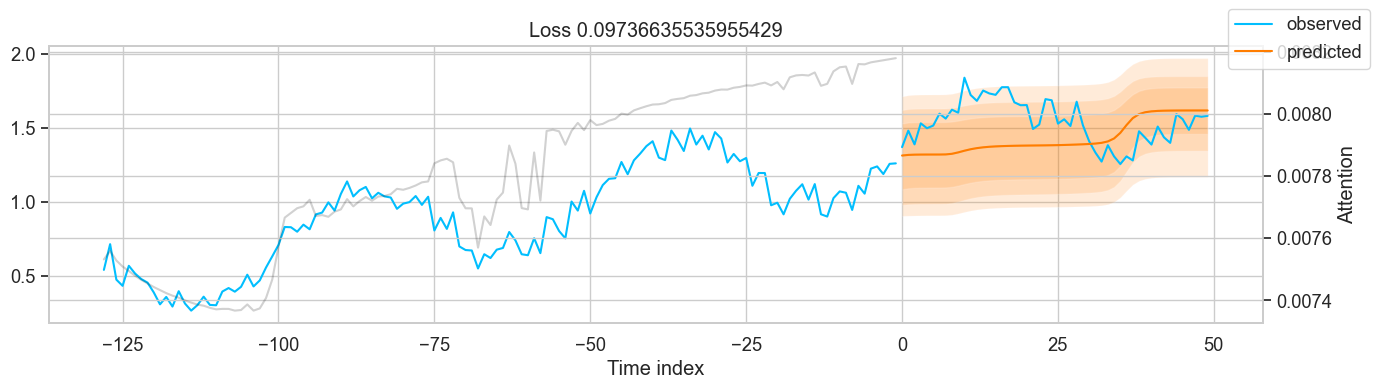

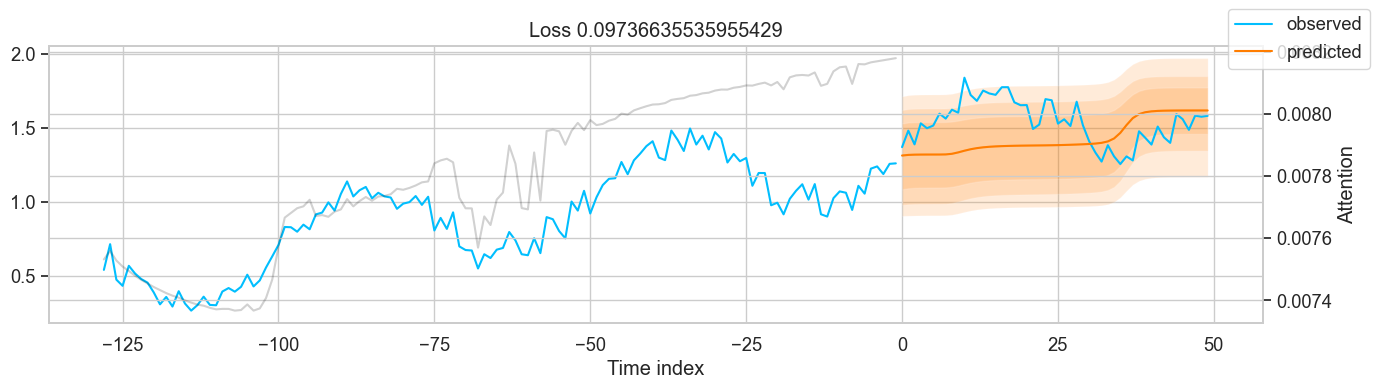

In [73]:
best_tft.plot_prediction(  #  Wizualizuje predykcję dla wybranego przykładu (idx=0) wraz z informacją o błędzie.
    raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True
)

In [74]:
best_tft.predict(  # Generuje predykcję dla specyficznej grupy (Group) i wybranego kroku czasowego
    training.filter(
        lambda x: (x.Group == "group") & (x.time_idx_first_prediction == 115)
    ),
    mode="quantiles",  # mode="quantiles": Zwraca predykcje kwantylowe, uwzględniając niepewność prognoz.
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


tensor([[[-1.2994, -1.2332, -1.1366, -0.9329, -0.6869, -0.6007, -0.5180],
         [-1.2986, -1.2300, -1.1319, -0.9302, -0.6827, -0.5956, -0.5124],
         [-1.2980, -1.2289, -1.1302, -0.9291, -0.6815, -0.5943, -0.5107],
         [-1.2975, -1.2283, -1.1294, -0.9285, -0.6811, -0.5940, -0.5101],
         [-1.2972, -1.2280, -1.1289, -0.9280, -0.6809, -0.5939, -0.5099],
         [-1.2969, -1.2276, -1.1284, -0.9276, -0.6808, -0.5939, -0.5096],
         [-1.2965, -1.2272, -1.1278, -0.9271, -0.6806, -0.5937, -0.5093],
         [-1.2960, -1.2267, -1.1271, -0.9265, -0.6803, -0.5935, -0.5089],
         [-1.2953, -1.2260, -1.1262, -0.9257, -0.6798, -0.5929, -0.5081],
         [-1.2944, -1.2249, -1.1249, -0.9246, -0.6789, -0.5920, -0.5069],
         [-1.2933, -1.2234, -1.1231, -0.9231, -0.6774, -0.5904, -0.5051],
         [-1.2921, -1.2214, -1.1208, -0.9209, -0.6752, -0.5880, -0.5026],
         [-1.2905, -1.2188, -1.1179, -0.9182, -0.6723, -0.5849, -0.4994],
         [-1.2887, -1.2156, -1.1144, -

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


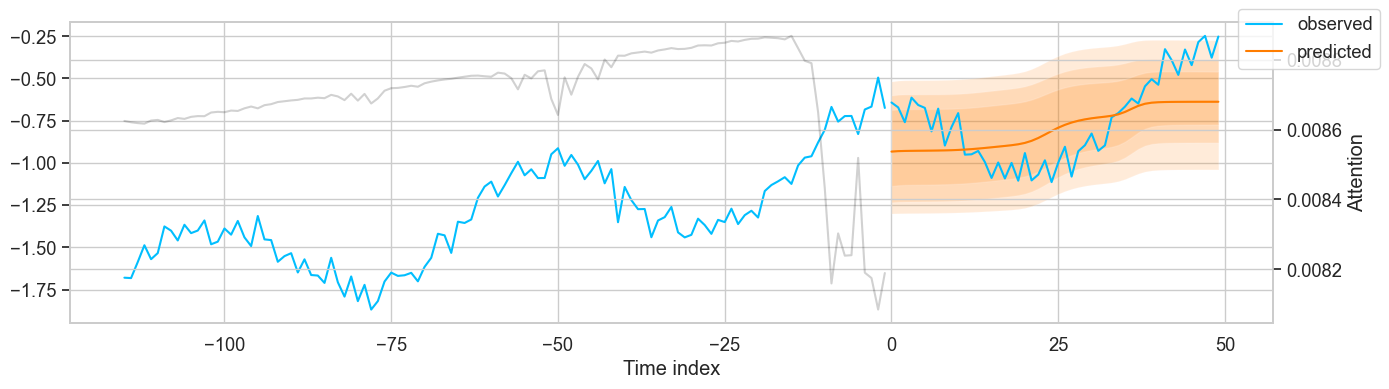

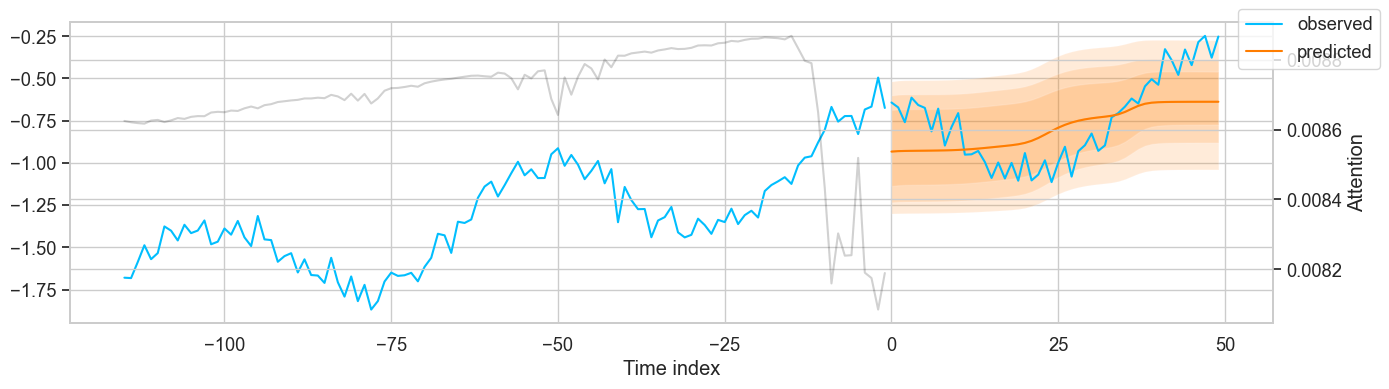

In [75]:
raw_prediction = best_tft.predict(
    training.filter(
        lambda x: (x.Group == "group")
        & (
            x.time_idx_first_prediction == 115
        )  # Generuje surowe predykcje (mode="raw") dla określonej grupy (Group) i punktu czasowego
    ),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(
    raw_prediction.x, raw_prediction.output, idx=0
)  # Wizualizuje wyniki dla pierwszego przykładu (idx=0), uwzględniając prognozy i dane wejściowe.

In [76]:
future_steps = 50
last_time = data["Time"].max()

future_data = pd.DataFrame(  # Tworzona jest ramka danych
    {
        "Time": list(range(last_time + 1, last_time + 1 + future_steps)),
        "Value": [0] * future_steps,  # Wartości mogą być puste (np. NaN)
        "Group": ["group"] * future_steps,  # Taka sama grupa jak podczas treningu
    }
)

In [77]:
new_prediction_data = pd.concat(
    [data, future_data]
).reset_index(
    drop=True
)  # Historyczne dane (data) są łączone z przyszłymi (future_data), a indeksy są resetowane.

new_prediction_dataset = TimeSeriesDataSet.from_dataset(  # Tworzy nowy obiekt TimeSeriesDataSet na podstawie istniejącego zbioru training
    training,
    new_prediction_data,
    predict=True,  # Przewidujemy przyszłe wartości
    stop_randomization=True,  # Utrzymujemy sekwencję bez losowego podziału
)

new_prediction_loader = new_prediction_dataset.to_dataloader(  # Loader danych, który dostarcza batchy z nowego zbioru danych do modelu podczas przewidywania.
    train=False, batch_size=1, num_workers=0
)

raw_predictions = best_tft.predict(
    new_prediction_loader, mode="raw", return_x=True
)  # Zwraca szczegółowe dane wejściowe i wyjściowe dla przyszłych prognoz

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


In [78]:
# 1. Uzyskaj predykcje dla nowych danych
predictions = best_tft.predict(new_prediction_loader)

# 2. Połącz dane historyczne i przewidywane
data_with_predictions = new_prediction_data.copy()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


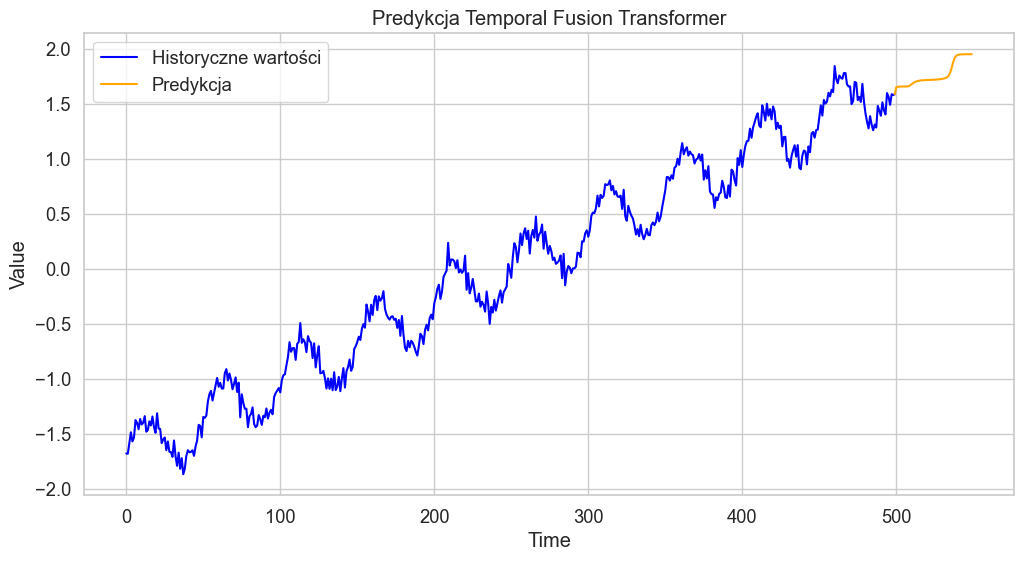

In [79]:
# predykcje do kolumny Value (dla przyszłych kroków)
data_with_predictions.loc[data_with_predictions["Time"] > 499, "Value"] = (
    predictions.squeeze().cpu().numpy()
)

# dane historyczne i predykcje
plt.figure(figsize=(12, 6))
plt.plot(
    data_with_predictions.loc[data_with_predictions["Time"] <= 499, "Time"],
    data_with_predictions.loc[data_with_predictions["Time"] <= 499, "Value"],
    label="Historyczne wartości",
    color="blue",
)
plt.plot(
    data_with_predictions.loc[data_with_predictions["Time"] >= 499, "Time"],
    data_with_predictions.loc[data_with_predictions["Time"] >= 499, "Value"],
    label="Predykcja",
    color="orange",
)
# plt.axvline(x=500, color='gray', linestyle='--', label="Początek predykcji")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Predykcja Temporal Fusion Transformer")
plt.legend()
plt.grid(True)
plt.show()

Teraz trening na zbiorze pomniejszonym o 50 wartości

In [80]:
data2 = data[:450]

future_steps = 50
last_time = data2["Time"].max()

future_data = pd.DataFrame(
    {
        "Time": list(range(last_time + 1, last_time + 1 + future_steps)),
        "Value": [0] * future_steps,  # Wartości mogą być puste (np. NaN)
        "Group": ["group"] * future_steps,  # Taka sama grupa jak podczas treningu
    }
)

new_prediction_data = pd.concat([data2, future_data]).reset_index(drop=True)

In [81]:
new_prediction_dataset = TimeSeriesDataSet.from_dataset(
    training,
    new_prediction_data,
    predict=True,  # Przewidujemy przyszłe wartości
    stop_randomization=True,  # Utrzymujemy sekwencję bez losowego podziału
)
new_prediction_loader = new_prediction_dataset.to_dataloader(
    train=False, batch_size=1, num_workers=0
)
# raw_predictions = best_tft.predict(new_prediction_loader, mode="raw", return_x=True)

predictions = best_tft.predict(new_prediction_loader)
data_with_predictions = new_prediction_data.copy()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


In [85]:
data["Time"]

0        0
1        1
2        2
3        3
4        4
      ... 
495    495
496    496
497    497
498    498
499    499
Name: Time, Length: 500, dtype: int64

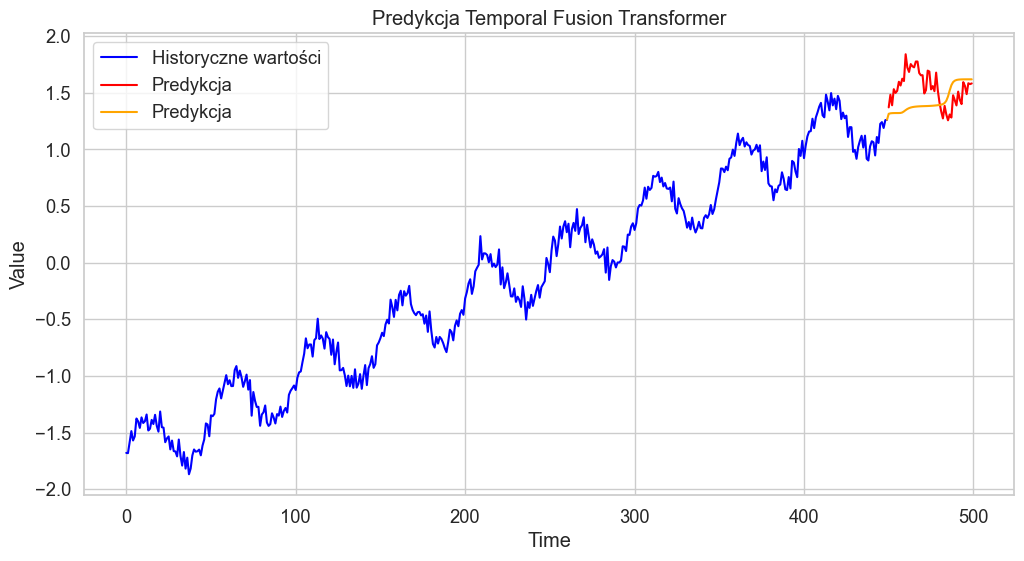

RMSE: 0.2316
R² Score: -1.5622


In [88]:
from functions_for_notebook import stats

# 3. Wstaw predykcje do kolumny Value (dla przyszłych kroków)
data_with_predictions.loc[data_with_predictions["Time"] > 449, "Value"] = (
    predictions.squeeze().cpu().numpy()
)

# 4. Wykres: dane historyczne i predykcje
plt.figure(figsize=(12, 6))
plt.plot(
    data_with_predictions.loc[data_with_predictions["Time"] <= 449, "Time"],
    data_with_predictions.loc[data_with_predictions["Time"] <= 449, "Value"],
    label="Historyczne wartości",
    color="blue",
)
plt.plot(
    data["Time"][-50:],
    data["Value"][-50:],
    label="Predykcja",
    color="red",
)

plt.plot(
    data_with_predictions.loc[data_with_predictions["Time"] >= 449, "Time"],
    data_with_predictions.loc[data_with_predictions["Time"] >= 449, "Value"],
    label="Predykcja",
    color="orange",
)
# plt.axvline(x=500, color='gray', linestyle='--', label="Początek predykcji")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Predykcja Temporal Fusion Transformer")
plt.legend()
plt.grid(True)
plt.show()

r2, rmse = stats(
    real_values=data["Value"][-50:],
    test_predictions=data_with_predictions.loc[
        data_with_predictions["Time"] >= 450, "Value"
    ],
)

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Yahoo finance API

In [89]:
import yfinance as yf
from datetime import date

# Ustawiamy zakres dat od 1990-01-01 do dnia dzisiejszego
end_date = date.today().strftime("%Y-%m-%d")
start_date = "1990-01-01"

# Dane pobieramy z yahoo
df = yf.download("SXR8.DE", start=start_date, end=end_date)

# Inspect the data
print(df.head())
print(df.info())

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open  Volume
Ticker        SXR8.DE    SXR8.DE    SXR8.DE    SXR8.DE SXR8.DE
Date                                                          
2010-05-19  92.669998  92.669998  92.669998  92.669998       0
2010-05-20  92.669998  92.669998  92.669998  92.669998       0
2010-05-21  92.669998  92.669998  92.669998  92.669998       0
2010-05-24  92.669998  92.669998  92.669998  92.669998       0
2010-05-25  92.669998  92.669998  92.669998  92.669998       0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3720 entries, 2010-05-19 to 2025-01-07
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, SXR8.DE)   3720 non-null   float64
 1   (High, SXR8.DE)    3720 non-null   float64
 2   (Low, SXR8.DE)     3720 non-null   float64
 3   (Open, SXR8.DE)    3720 non-null   float64
 4   (Volume, SXR8.DE)  3720 non-null   int64  
dtypes: float64(4), int64(1)
memory 

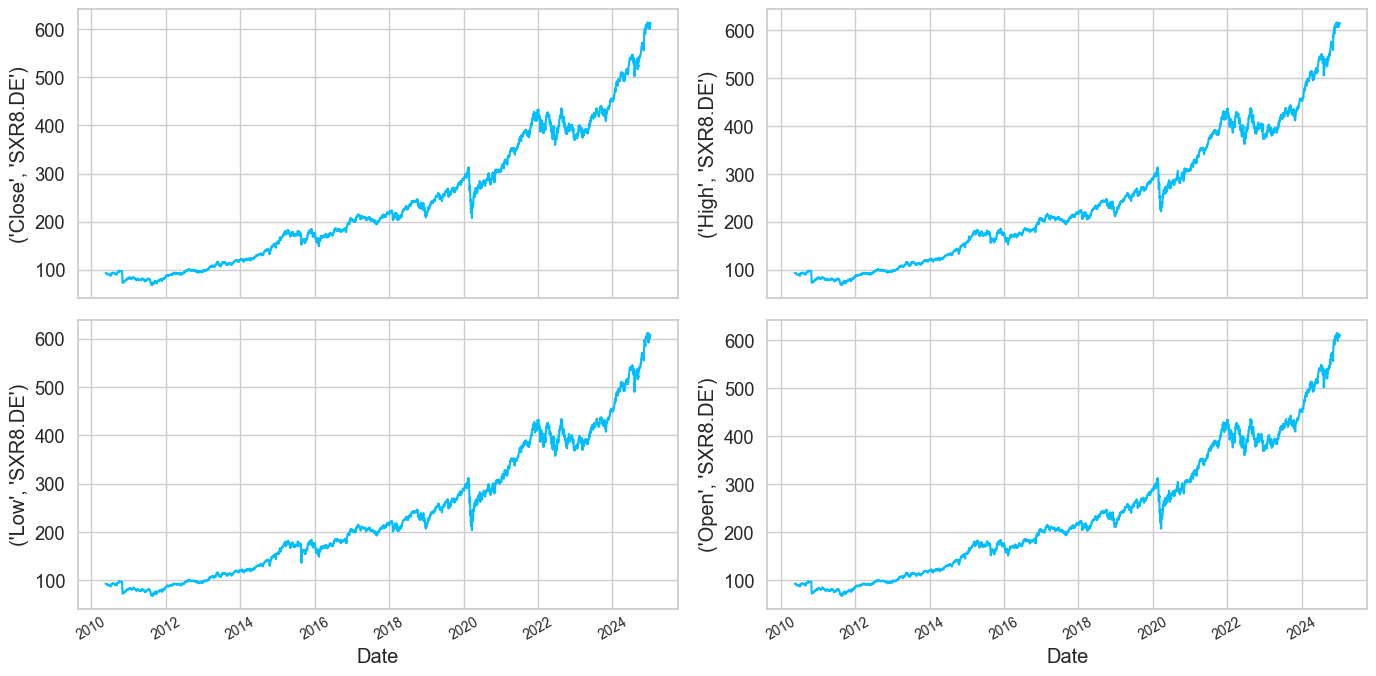

In [90]:
import matplotlib.dates as mdates


# Wizualizacja
def data_plot(df):
    df_plot = df.copy()

    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
        sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
    plt.show()


data_plot(df)

In [91]:
data_open = df["Open"]["SXR8.DE"].reset_index()
data_open.columns = ["Time", "Value"]
data_open

,Time,Value
0,2010-05-19,92.669998
1,2010-05-20,92.669998
2,2010-05-21,92.669998
3,2010-05-24,92.669998
4,2010-05-25,92.669998
...,...,...
3715,2024-12-30,605.880005
3716,2025-01-02,605.679993
3717,2025-01-03,607.080017
3718,2025-01-06,611.039978


In [92]:
from sklearn.preprocessing import StandardScaler

data = data_open.copy()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[["Value"]])  # Dopasowanie do danych
data["Value"] = scaled_data  # Nadpisanie znormalizowanych wartości

In [94]:
group = ["group" for i in range(len(data))]
time = [i for i in range(len(data))]
data["Group"] = group
data["Time"] = time
data.sample(10, random_state=521)

,Time,Value,Group
1080,1080,-0.795180,group
36,36,-1.136846,group
2398,2398,0.229073,group
915,915,-0.917974,group
366,366,-1.216402,group
1465,1465,-0.568345,group
1450,1450,-0.574225,group
1233,1233,-0.513870,group
3460,3460,1.580480,group
535,535,-1.086835,group


In [95]:
max_prediction_length = 50
max_encoder_length = 128
training_cutoff = data["Time"].max() - max_prediction_length
training_cutoff

training = TimeSeriesDataSet(
    data[lambda x: x.Time <= training_cutoff],
    time_idx="Time",
    target="Value",
    group_ids=["Group"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=["Time"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["Value"],
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [96]:
validation = TimeSeriesDataSet.from_dataset(
    training, data, predict=True, stop_randomization=True
)


batch_size = 128
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size * 10, num_workers=0
)

In [99]:
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min"
)
lr_logger = LearningRateMonitor()
# logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,
    # fast_dev_run=True,
    callbacks=[lr_logger, early_stop_callback],
    # logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size() / 1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 18.6k


c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:171: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defau

In [100]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 96     | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.8 K  | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm |

c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_e

Epoch 10: 100%|██████████| 28/28 [00:04<00:00,  5.65it/s, v_num=89, train_loss_step=0.0337, val_loss=0.0758, train_loss_epoch=0.0336]


In [101]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [102]:
predictions = best_tft.predict(
    val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu")
)
MAE()(predictions.output, predictions.y)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


tensor(0.1575, device='cuda:0')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


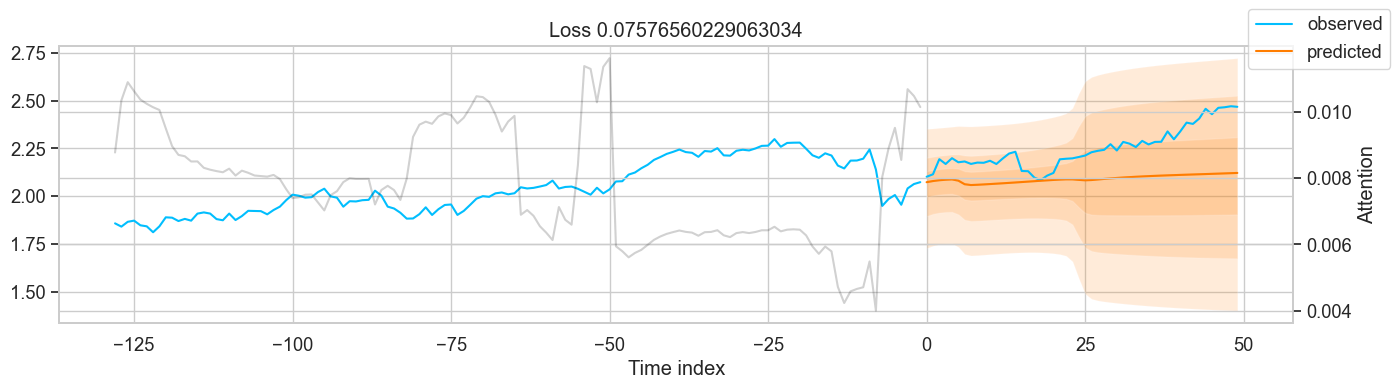

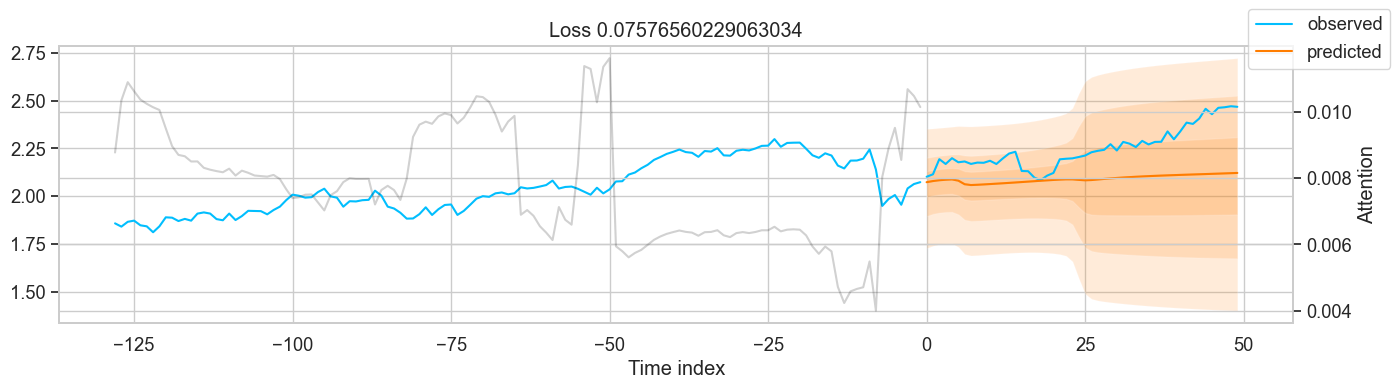

In [103]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

best_tft.plot_prediction(
    raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True
)

In [104]:
best_tft.predict(
    training.filter(
        lambda x: (x.Group == "group") & (x.time_idx_first_prediction == 115)
    ),
    mode="quantiles",
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


tensor([[[-1.1483, -1.1141, -1.0960, -1.0821, -1.0656, -1.0543, -1.0310],
         [-1.1756, -1.1348, -1.1073, -1.0850, -1.0585, -1.0408, -1.0148],
         [-1.2115, -1.1656, -1.1236, -1.0893, -1.0540, -1.0297, -0.9983],
         [-1.2400, -1.1917, -1.1378, -1.0939, -1.0535, -1.0245, -0.9889],
         [-1.2556, -1.2066, -1.1462, -1.0972, -1.0548, -1.0234, -0.9853],
         [-1.2642, -1.2148, -1.1505, -1.0986, -1.0555, -1.0227, -0.9825],
         [-1.2695, -1.2198, -1.1529, -1.0992, -1.0556, -1.0220, -0.9803],
         [-1.2743, -1.2239, -1.1551, -1.0999, -1.0560, -1.0214, -0.9787],
         [-1.2787, -1.2274, -1.1571, -1.1009, -1.0566, -1.0211, -0.9777],
         [-1.2817, -1.2297, -1.1586, -1.1019, -1.0574, -1.0212, -0.9776],
         [-1.2834, -1.2311, -1.1596, -1.1027, -1.0582, -1.0216, -0.9779],
         [-1.2844, -1.2319, -1.1603, -1.1033, -1.0588, -1.0221, -0.9784],
         [-1.2850, -1.2324, -1.1607, -1.1038, -1.0593, -1.0225, -0.9789],
         [-1.2853, -1.2328, -1.1611, -

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


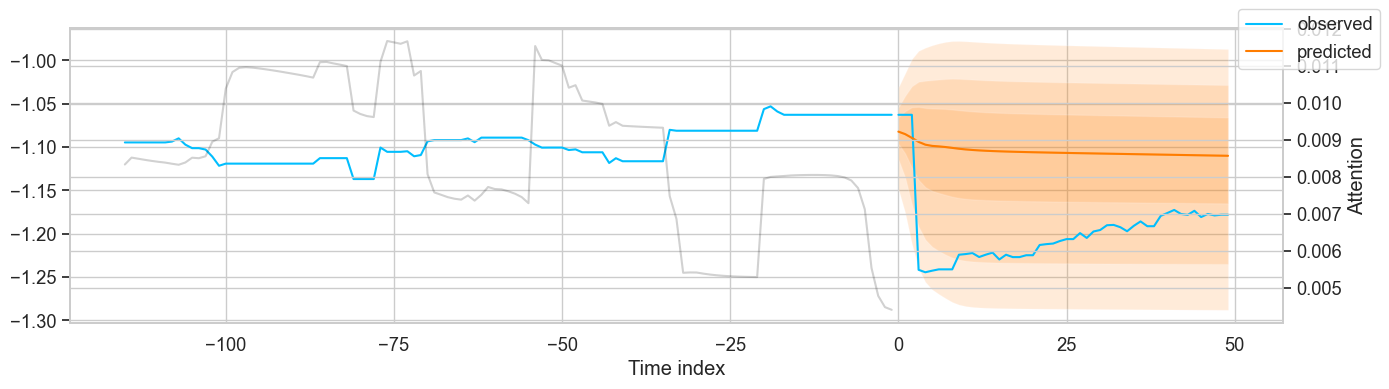

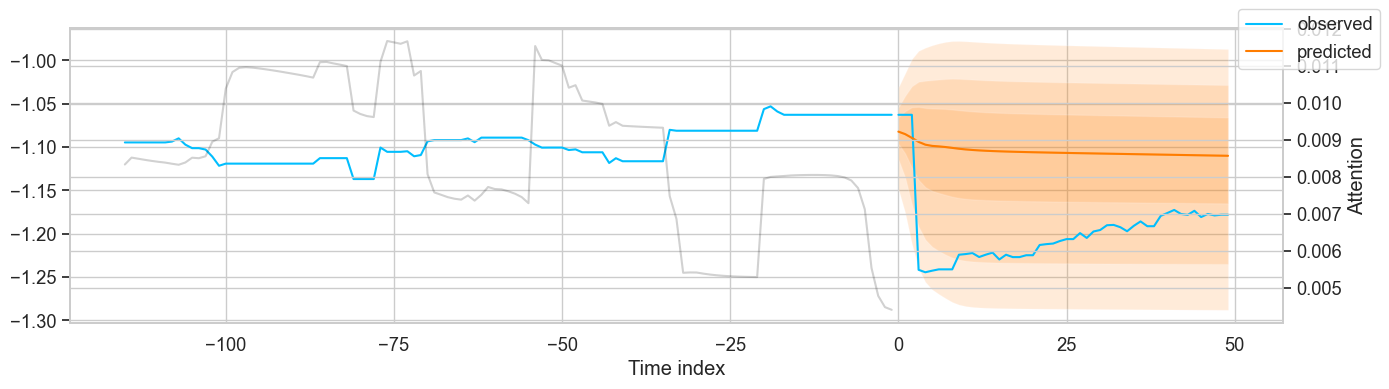

In [105]:
raw_prediction = best_tft.predict(
    training.filter(
        lambda x: (x.Group == "group") & (x.time_idx_first_prediction == 115)
    ),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

In [106]:
future_steps = 50
last_time = data["Time"].max()

future_data = pd.DataFrame(
    {
        "Time": list(range(last_time + 1, last_time + 1 + future_steps)),
        "Value": [0] * future_steps,  # Wartości mogą być puste (np. NaN)
        "Group": ["group"] * future_steps,  # Taka sama grupa jak podczas treningu
    }
)

In [107]:
new_prediction_data = pd.concat([data, future_data]).reset_index(drop=True)

new_prediction_dataset = TimeSeriesDataSet.from_dataset(
    training,
    new_prediction_data,
    predict=True,  # Przewidujemy przyszłe wartości
    stop_randomization=True,  # Utrzymujemy sekwencję bez losowego podziału
)

In [108]:
new_prediction_loader = new_prediction_dataset.to_dataloader(
    train=False, batch_size=1, num_workers=0
)

raw_predictions = best_tft.predict(new_prediction_loader, mode="raw", return_x=True)

# 1. Uzyskaj predykcje dla nowych danych
predictions = best_tft.predict(new_prediction_loader)

# 2. Połącz dane historyczne i przewidywane
data_with_predictions = new_prediction_data.copy()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\ortek\AppData\Local\pypoetry\Cache\virtualenvs\forecasting-uBk3YmnA-py3.12\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=

In [109]:
predictions = predictions.squeeze().cpu().numpy()

predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
data_with_predictions["Value"] = scaler.inverse_transform(
    np.array(data_with_predictions["Value"]).reshape(-1, 1)
).flatten()

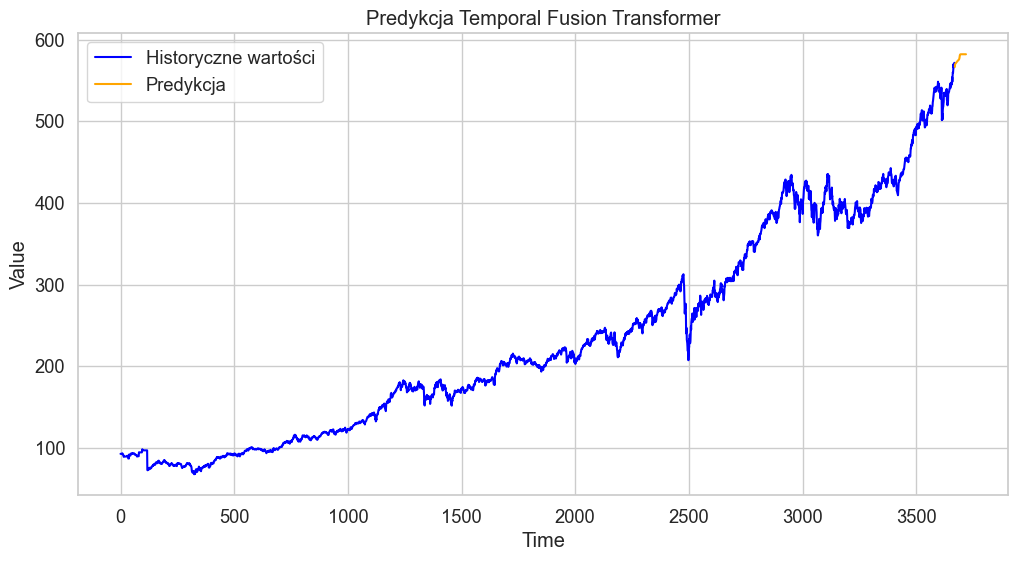

In [110]:
plt.figure(figsize=(12, 6))
plt.plot(
    data_with_predictions[:-50]["Time"],
    data_open[:-50]["Value"],
    label="Historyczne wartości",
    color="blue",
)
plt.plot(
    data_with_predictions["Time"][-50:],
    predictions,
    label="Predykcja",
    color="orange",
)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Predykcja Temporal Fusion Transformer")
plt.legend()
plt.grid(True)
plt.show()

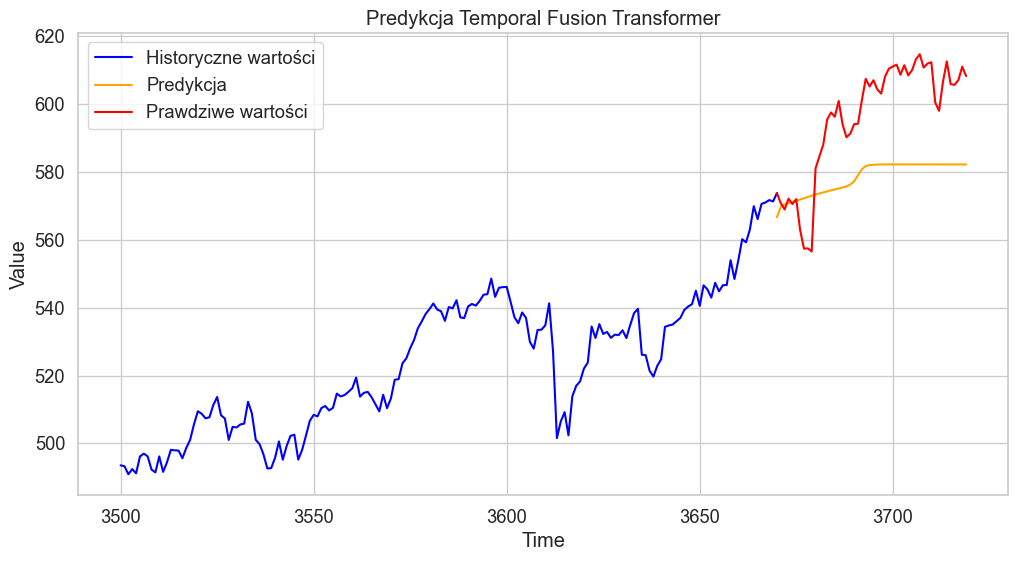

In [111]:
plt.figure(figsize=(12, 6))
plt.plot(
    data_with_predictions[3500:-49]["Time"],
    data_open[3500:-49]["Value"],
    label="Historyczne wartości",
    color="blue",
)
plt.plot(
    data_with_predictions["Time"][-50:],
    predictions,
    label="Predykcja",
    color="orange",
)

plt.plot(
    data_with_predictions[-50:]["Time"],
    data_open["Value"][-50:],
    label="Prawdziwe wartości",
    color="red",
)
# plt.axvline(x=500, color='gray', linestyle='--', label="Początek predykcji")
plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Predykcja Temporal Fusion Transformer")
plt.legend()
plt.grid(True)
plt.show()